<a href="https://colab.research.google.com/github/NasimAkhtar03/FashionMNIST-Detection-VGG-16-PyTorch/blob/main/FashionMNIST_VGG_transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('fashionmnist-vgg-transfer-learning-pytorch-ee68a')
jovian.set_colab_id('1lwdVpRvjtVJu4xNjKfHt1YiHjUJwWWo9')

# Setting up Environment

In [ ]:
# Data Science Tools
import numpy as np
import pandas as pd
import os

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda, optim
from torch.utils.data import DataLoader, random_split

# Useful library for examining network
from torchsummary import summary

# Model, Datasets and transformations
import torchvision
import torchvision.transforms as T
from torchvision.datasets import FashionMNIST
from torchvision.models import vgg16, vgg19, vgg16_bn, vgg19_bn

# Timing utility
from timeit import default_timer as timer

# Log outputs
from TrainingLog import TrainingLog

In [ ]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Select Device
device = torch.device("cuda:0" if train_on_gpu else "cpu")

# Number of gpus
multi_gpu = False
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


# Save and Load Checkpoints

In [ ]:
def save_checkpoint(model, optimizer, training_history, file_path="checkpoint.tar"):
    checkpoint = {
        'model': model,
        'model_state_dict': model.state_dict(),
        'optimizer': optimizer,
        'optimizer_state_dict': optimizer.state_dict(),
        'epochs': model.epochs,
        'training_history': training_history
    }
    torch.save(checkpoint, file_path)

def load_checkpoint(file_path="checkpoint.tar", train_on_gpu=False):
    if train_on_gpu:
        return torch.load(checkpoint_file, map_location='cuda:0')
    else:
        return torch.load(checkpoint_file)

def save_best_model(model, file_path="best_model.pt"):
    best_model = {
        'model': model,
        'state_dict': model.state_dict(),
        'epochs_trained': model.epochs if hasattr(model, 'epochs') else None
    }
    torch.save(best_model, file_path)

def load_best_model(file_path="best_model.pt"):
    best_model = torch.load(file_path)
    model = best_model['model']
    model.load_state_dict(best_model['state_dict'])
    model.epochs = best_model['epochs_trained']
    return model

# Preparing the Dataset

In [ ]:
train_size, valid_size = 50000, 10000
random_seed = 0
torch.manual_seed(random_seed)

best_model_file_path = "best_model.pt"
checkpoint_file = "checkpoint.tar"
learning_rate = 0.01
momentum = 0.5

In [ ]:
transform = T.Compose([
    T.Resize(size=32),
    # T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize((0.2860,), (0.3530,))
])

trainval_set = FashionMNIST(root='./data', download=True, transform=transform)
train_set, valid_set = random_split(trainval_set, [train_size, valid_size])
test_set = FashionMNIST(root='./data', train=False, transform=transform)
classes = {v:k for k,v in trainval_set.class_to_idx.items()}

In [ ]:
batch_size = 200

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Exploring the Dataset

In [ ]:
print("Training Data Size:", len(train_set))
print("Validation Data Size:", len(valid_set))
print("Test Data Size:", len(test_set))
print("Classes:")
classes

Training Data Size: 50000
Validation Data Size: 10000
Test Data Size: 10000
Classes:


{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

## Example from each category

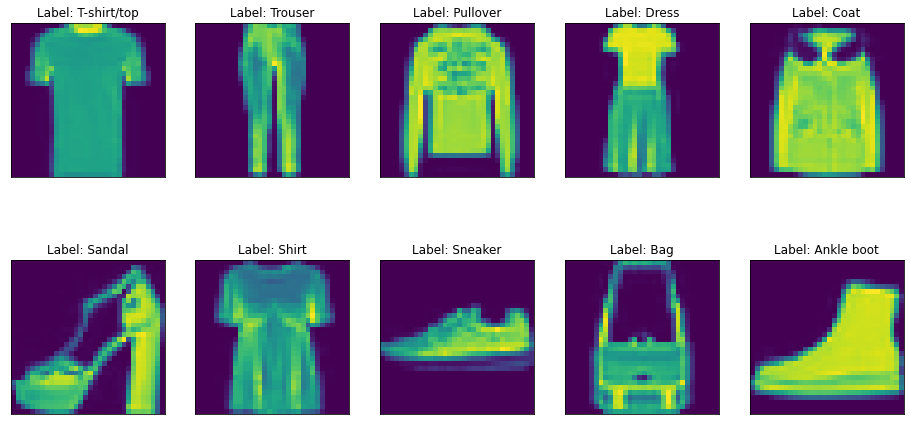

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Take 1 example from each categoty
accuired_lebels = set()
subset = []
for data, lebel in train_set:
    if lebel not in accuired_lebels:
        subset.append((lebel, data))
        accuired_lebels.add(lebel)
        if len(accuired_lebels) == 10: break
subset.sort(key=lambda x: x[0])

plt.figure(figsize=(16, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(subset[i][1].numpy()[0])
    plt.title("Label: {}".format(classes[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Building the Model

## Loading pretrained Model, Optimizer and Training History

In [ ]:
# If Model is found in local directory
if os.path.exists(checkpoint_file):
    # Load Checkpoint
    checkpoint = load_checkpoint(checkpoint_file, train_on_gpu)
    
    # Load Model
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    model.epochs = checkpoint['epochs']

    # Load Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load Training History
    training_history = checkpoint['training_history']
    del checkpoint

# If the model is not found in local directory then download it
# And Define Optimizer and training history
else:
    # Download pretrained model
    model = vgg16(pretrained=True)
    
    # Keeping gradients for pretrained weights fixed
    for param in model.parameters():
        param.requires_grad = False
    
    # Add one convolution layer at first in model.features
    features = list(model.features)
    features = [nn.Conv2d(1, 3, kernel_size=3, padding=1), nn.ReLU()] + features
    model.features = nn.Sequential(*features)

    # Add required classifier layers in model.classifier
    num_inputs = model.classifier[6].out_features
    classifier = list(model.classifier)
    classifier.extend([
        nn.ReLU(),
        nn.Linear(num_inputs, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, len(classes)),
        nn.LogSoftmax(dim=1)
    ])
    model.classifier = nn.Sequential(*classifier)

    # Set 'epochs' attribute in model to keep track of of epochs trained
    model.epochs = 0
    
    # Define Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                                momentum=momentum)
    
    # Define DataFrame to keep track of training and
    # Validation loss and accuracy
    training_history = pd.DataFrame( 
        columns=[
            'train_loss', 'valid_loss', 
            'train_acc', 'valid_acc'
        ]
    )
    
    # Add Checkpoint
    save_checkpoint(model, optimizer, training_history)
    
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

## Calculating total and training parameters

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

139,043,216 total parameters.
685,672 training parameters.


## Moving the model to GPU if it is found



In [ ]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

## Show Model Summary

In [ ]:
summary(model, input_size=train_set[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              30
              ReLU-2            [-1, 3, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]           1,792
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

# Training the Model

## Defining Loss Function

In [ ]:
criterion = nn.NLLLoss()

## Defining Training Process

In [ ]:
def train(model, 
          criterion, 
          optimizer, 
          train_loader, 
          valid_loader, 
          checkpoint_file,
          best_model_file_path, 
          training_history=None, 
          max_epochs_stop=3, 
          n_epochs=20, 
          train_on_gpu=False, 
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        checkpoint_file (str ending in '.tar'): file path to save checkpoint
        best_model_file_path (str ending in '.pt'): file path to save the model state dict
        training_history (Pandas DataFrame): A DataFrame for storing training and validation loss and accuracy
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        training_history (DataFrame): history of train and validation loss and accuracy
    """

    log = TrainingLog()
    
    # If early stopping is not chosen
    if max_epochs_stop == 0:
        max_epochs_stop = n_epochs

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    if training_history is None:
        training_history = pd.DataFrame(
            columns=[
                'train_loss', 'valid_loss', 
                'train_acc', 'valid_acc'
            ]
        )
    elif isinstance(training_history, pd.DataFrame) and not training_history.empty:
        print("Previous Training History:")
        print(training_history)

    # Number of epochs already trained (if using loaded in model weights)
    if not hasattr(model, 'epochs') or model.epochs == 0:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')
    else:
        print(f'Model has been trained for: {model.epochs} epochs.\n')

    prev_epochs = model.epochs
        
    # try:
    #     print(f'Model has been trained for: {model.epochs} epochs.\n')
    # except:
    #     model.epochs = 0
    #     print(f'Starting Training from Scratch.\n')

    overall_start = timer()
    log.print_header()

    # Main loop
    for epoch in range(n_epochs):
        log.update_row(epoch_num=model.epochs + 1)

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0.0
        valid_acc = 0.0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            log.update_row(tp=(ii+1)/len(train_loader), tt=timer()-start)

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Calculate average train loss and accuracy
            train_loss = train_loss / len(train_loader.dataset)
            train_acc = train_acc / len(train_loader.dataset)

            # Print Training Result
            log.update_row(tl=train_loss, ta=train_acc)

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                start = timer()
                for jj, (data, target) in enumerate(valid_loader):
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                    
                    # Track validation progress
                    log.update_row(vp=(jj+1)/len(valid_loader), vt=timer()-start)

                # Calculate average validation loss and accuracy
                valid_loss = valid_loss / len(valid_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                # Print Validation Result
                log.update_row(vl=valid_loss, va=valid_acc)

                # training_history.append([train_loss, valid_loss, train_acc, valid_acc])
                training_history.loc[model.epochs] = {
                    'train_loss': train_loss,
                    'valid_loss': valid_loss,
                    'train_acc' : train_acc,
                    'valid_acc' : valid_acc
                }

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save checkpoint
                    save_checkpoint(model, optimizer, training_history, checkpoint_file)
                    # torch.save(model.state_dict(), best_model_file_path)
                    
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch + 1

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        log.finish()
                        print(
                            f'\nEarly Stopping! Total epochs: {prev_epochs + epoch + 1}. ' \
                            f'Best epoch: {prev_epochs + best_epoch} with ' \
                            f'loss: {valid_loss_min:.4f} and acc: {valid_best_acc:.2%}'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        checkpoint = load_checkpoint(checkpoint_file, train_on_gpu)   
                        model.load_state_dict(checkpoint['model_state_dict'])
                        
                        # Attach the optimizer
                        model.optimizer = optimizer
                        
                        # Save checkpoint
                        save_checkpoint(model, optimizer, training_history, checkpoint_file)
                        save_best_model(model, best_model_file_path)
                        
                        # Return Best Model and latest training_history
                        return model, training_history
        if (epoch + 1) % print_every == 0:
            log.new_row()
    log.finish()
    
    # Load the best state dict
    checkpoint = load_checkpoint(checkpoint_file, train_on_gpu) 
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Attach the optimizer
    model.optimizer = optimizer
    
    # Save checkpoint
    save_checkpoint(model, optimizer, training_history, checkpoint_file)
    save_best_model(model, best_model_file_path)

    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {prev_epochs + best_epoch} with loss: {valid_loss_min:.2f} and acc: {valid_best_acc:.2%}'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.'
    )
    
    return model, training_history

## Training

In [ ]:
trained_model, training_history = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    checkpoint_file=checkpoint_file,
    best_model_file_path=best_model_file_path, 
    training_history=training_history, 
    max_epochs_stop=10,
    n_epochs=100,
    train_on_gpu=train_on_gpu,
    print_every=5
)

Starting Training from Scratch.


|       |                 Training                 |                Validation                |
| Epoch |------------------------------------------|------------------------------------------|
|       |      Progress      |   Loss   | Accuracy |      Progress      |   Loss   | Accuracy |
|-------|--------------------|----------|----------|--------------------|----------|----------|
|   5   |  100.00% (25.37s)  |  0.6996  |  74.14%  |  100.00% (2.74s)   |  0.6529  |  76.08%  |
|  10   |  100.00% (25.50s)  |  0.6081  |  77.31%  |  100.00% (2.77s)   |  0.5792  |  78.38%  |
|  15   |  100.00% (25.57s)  |  0.5695  |  78.71%  |  100.00% (2.78s)   |  0.5345  |  80.21%  |
|  20   |  100.00% (25.42s)  |  0.5458  |  79.48%  |  100.00% (2.75s)   |  0.5281  |  80.43%  |
|  25   |  100.00% (25.34s)  |  0.5282  |  80.21%  |  100.00% (2.75s)   |  0.5202  |  80.93%  |
|  30   |  100.00% (25.40s)  |  0.5109  |  80.82%  |  100.00% (2.76s)   |  0.4897  |  82.15%  |
|  35 

## Training Results

### Training and Validation Losses

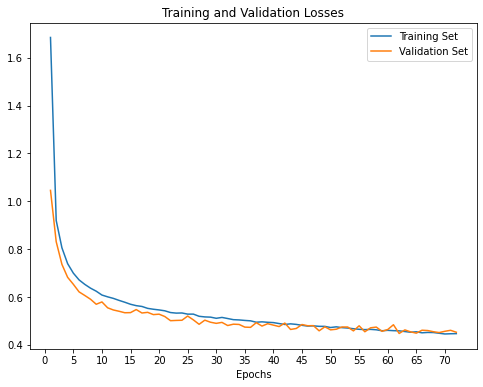

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(training_history['train_loss'], label='Training Set')
plt.plot(training_history['valid_loss'], label='Validation Set')
plt.legend()
plt.title("Training and Validation Losses")
plt.xticks(np.arange(len(training_history) + 1, step=5))
plt.xlabel("Epochs")
plt.show()

### Training and Validation Accuracies

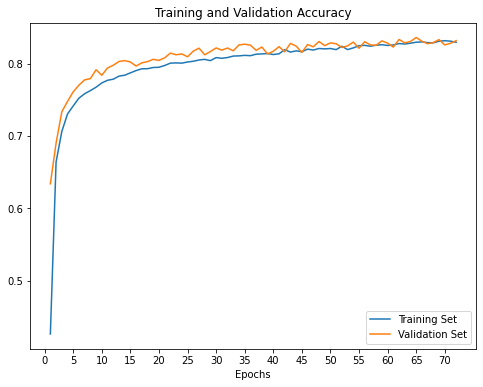

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(training_history['train_acc'], label='Training Set')
plt.plot(training_history['valid_acc'], label='Validation Set')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xticks(np.arange(len(training_history) + 1, step=5))
plt.xlabel("Epochs")
plt.show()

# Evaluation

## Testing of the Trained Model

In [ ]:
def evaluate(model, criterion, data_loader):
    total_loss = 0
    total_acc = 0

    model.eval()
    for data, target in data_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward Pass
        output = model(data)

        # Loss
        loss = criterion(output, target)
        # Multiply average loss times the number of examples in batch
        total_loss += loss.item() * data.size(0)

        # Calculate accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(
            correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        total_acc += accuracy.item() * data.size(0)

    total_loss = total_loss / len(data_loader.dataset)
    total_acc = total_acc / len(data_loader.dataset)

    return total_loss, total_acc


In [ ]:
avg_loss, accuracy = evaluate(trained_model, criterion, test_loader)
print("Average Test Loss: {:.4F}\nTest Accuracy: {:.2%}".format(avg_loss, accuracy))

Average Test Loss: 0.4559
Test Accuracy: 82.83%


## Evaluating the Model's Performance with some example

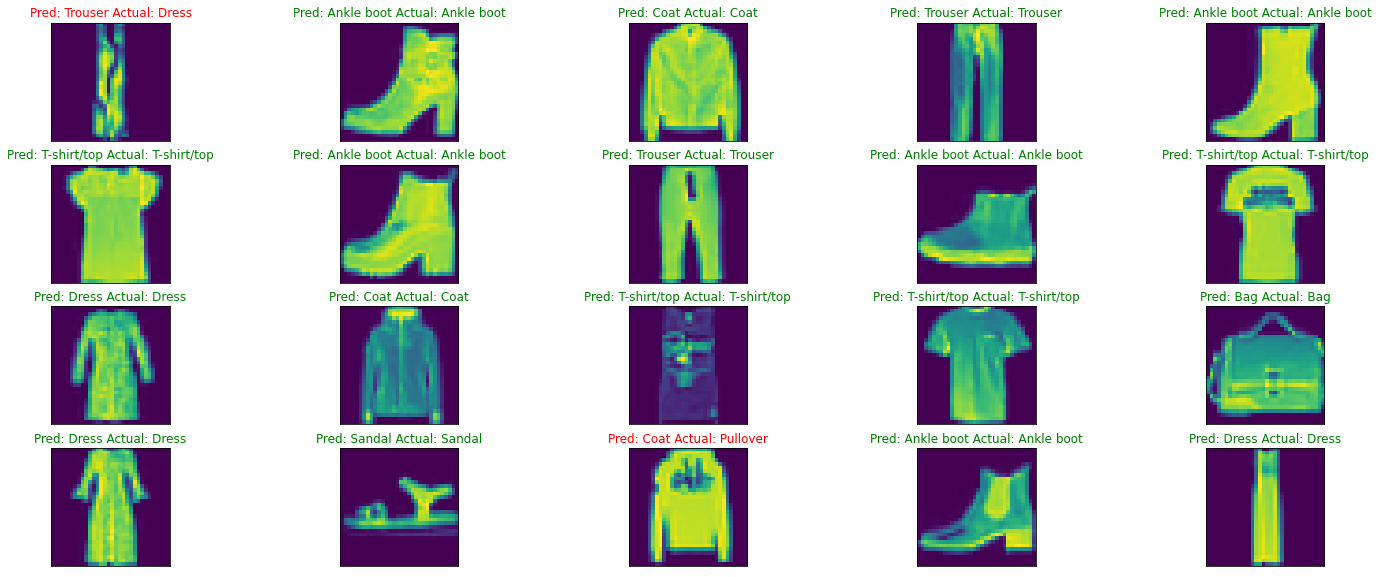

In [ ]:
from torch.utils.data import Subset

num_examples = 20

indices = np.random.randint(low=0, high=len(test_set), size=num_examples)
subset = Subset(test_set, indices)
subset_loader = DataLoader(subset, num_examples)
data, target = next(iter(subset_loader))
if train_on_gpu:
    data, target = data.cuda(), target.cuda()

output = trained_model(data)
_, pred = torch.max(output, dim=1)

plt.figure(figsize=(25, 10))
for idx in range(num_examples):
    plt.subplot(np.ceil(num_examples/5), 5, idx+1)
    plt.imshow(data[idx].cpu().numpy()[0])
    plt.xticks([])
    plt.yticks([])
    plt.title("Pred: {} Actual: {}".format(classes[pred[idx].item()], classes[target[idx].item()]),
              color= ('green' if pred[idx] == target[idx] else 'red'))
plt.show()

In [ ]:
jovian.commit(project="fashionmnist-vgg-transfer-learning-pytorch-ee68a",
              files=["TrainingLog.py"], outputs=["checkpoint.tar", 
                                                 "best_model.pt",
                                                 "best_model_parameters.pt"])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional files...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (checkpoint.tar)
[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (best_model.pt)
[jovian] Error: Ignoring "best_model_parameters.pt" (not found)


[jovian] Committed successfully! https://jovian.ai/arkonil/fashionmnist-vgg-transfer-learning-pytorch-ee68a


'https://jovian.ai/arkonil/fashionmnist-vgg-transfer-learning-pytorch-ee68a'